<a id='import'></a>
#### 1. Import

In [67]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix,auc,roc_auc_score
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score

from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance, to_graphviz
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder,LabelBinarizer

In [68]:
from sklearn.preprocessing import StandardScaler

In [69]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

In [70]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [71]:
df = pd.read_csv('sampledata.csv',nrows=100000)

In [72]:
df.shape
df.drop(['CSP location','CustomerName','RefNumber','TxnStatus'], axis=1, inplace=True)
df.fillna(0, inplace=True)

In [73]:
df['AuditStatus'] = df['AuditStatus'].replace(to_replace={'.*Fraud.*': '1'}, regex=True)
df.AuditStatus = pd.to_numeric(df.AuditStatus, errors='coerce')

#df['TxnStatus'] = df['TxnStatus'].replace(to_replace={'.*Success.*': '1'}, regex=True)
#df['TxnStatus'] = df['TxnStatus'].replace(to_replace={'.*Failure.*': '1'}, regex=True)

#df.TxnStatus = pd.to_numeric(df.TxnStatus, errors='coerce')

df.columns = df.columns.str.replace(' ', '')
print('Before')
print(df.head())

le = LabelEncoder()
df['CSPCode'] = le.fit_transform(df.CSPCode)
df['FromAccount'] = le.fit_transform(df.FromAccount)
df['ToAccount'] = le.fit_transform(df.ToAccount)
df['TxnType'] = le.fit_transform(df.TxnType)
df['TxnDateTime'] = le.fit_transform(df.TxnDateTime)

print('\n\n After')
print(df.head())

Before
    CSPCode  TerminalID              TxnDateTime               TxnType  \
0  1A69C733  10810701.0  2018-11-28 17:57:56.000               Deposit   
1  1A69C733  10810701.0  2018-11-28 17:59:23.000  ATM Offus Withdrawal   
2  1A69C733  10810701.0  2018-11-28 18:02:20.000        Money Transfer   
3  1A69C733  10810701.0  2018-11-28 18:10:37.000   ATM Onus Withdrawal   
4  1A69C733  10810701.0  2018-11-29 16:35:23.000  AEPS ONUS Withdrawal   

   FromAccount    ToAccount   Amount  CustomerCharge    JournalNo  AuditStatus  
0  XXXXXX59469  XXXXXX66910    900.0             0.0  110474040.0            0  
1  XXXXXX21052  XXXXXX59469   2000.0             0.0  110622933.0            1  
2  XXXXXX59469  XXXXXX64314    300.0             0.0  110965731.0            0  
3  XXXXXX19196  XXXXXX59469  10000.0             0.0  111946600.0            0  
4  XXXXXX53275  XXXXXX59469   1200.0             0.0   99376167.0            0  


 After
   CSPCode  TerminalID  TxnDateTime  TxnType  FromAcc

<a id='EDA'></a>
#### 2. Exploratory Data Analysis


<a id='fraud-trans'></a>
##### 2.1. Which types of transactions are fraudulent? 


In [74]:
print('\n The types of transactions tagged as Fraud Transaction are {}'.format(\
list(df.loc[df.AuditStatus == 1].TxnType.drop_duplicates().values))) # only 'CASH_OUT' 
                                                             # & 'TRANSFER'

FTs = list(df.loc[df.AuditStatus == 1].TxnType.drop_duplicates().values)
dfFraudTxns = df.loc[(df.AuditStatus == 1)]

print ('\n The number of fraud transactions = {}'.\
      format(len(dfFraudTxns))) # 4097


 The types of transactions tagged as Fraud Transaction are [7, 1, 6, 11, 8, 4, 21, 17, 14, 2, 3, 16, 5, 13, 12, 0]

 The number of fraud transactions = 29260


<a id='isFlaggedFraud'></a>
##### 2.2. What is min and max amount in Fraud Transactions? 


In [75]:

print('\nMin amount transacted in Fraud Transactions = {}'\
                                  .format(dfFraudTxns.Amount.min()))

print('\nMax amount transacted in Fraud Transactions = {}'\
                                  .format(dfFraudTxns.Amount.max()))


Min amount transacted in Fraud Transactions = 1.0

Max amount transacted in Fraud Transactions = 20000.0


<a id='clean'></a>
#### 3. Data cleaning

In [76]:
#X = df.loc[(df.TxnType in FTs)]
X = df.loc[df['TxnType'].isin(FTs)]


randomState = 5
np.random.seed(randomState)

#X = X.loc[np.random.choice(X.index, 100000, replace = False)]

Y = X['AuditStatus']
del X['AuditStatus']

# Binary-encoding of labelled data in 'type'
#X.loc[X.type == 'TRANSFER', 'type'] = 0
#X.loc[X.type == 'CASH_OUT', 'type'] = 1
#X.type = X.type.astype(int) # convert dtype('O') to dtype(int)

In [77]:
df['scaled_Amount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_TerminalID'] = StandardScaler().fit_transform(df['TerminalID'].values.reshape(-1,1))
df['scaled_JournalNo'] = StandardScaler().fit_transform(df['JournalNo'].values.reshape(-1,1))


<a id='visualization'></a>
#### 4. Data visualization

In [78]:
limit1 = len(X)
limit2 = len(df)

print('\nTotal transactions in categories with fraud = {}'\
                                  .format(limit1))
print('\nTotal transactions = {}'\
                                  .format(limit2))


Total transactions in categories with fraud = 96867

Total transactions = 100000


<a id='visualization'></a>
#### 4. Data visualization

Txns as pie chart:


Text(0, 0.5, '')

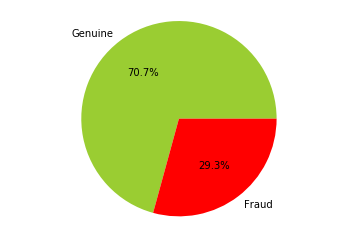

In [79]:
print("Txns as pie chart:")
fig, ax = plt.subplots(1, 1)
ax.pie(df.AuditStatus.value_counts(),autopct='%1.1f%%', labels=['Genuine','Fraud'], colors=['yellowgreen','r'])
plt.axis('equal')
plt.ylabel('')

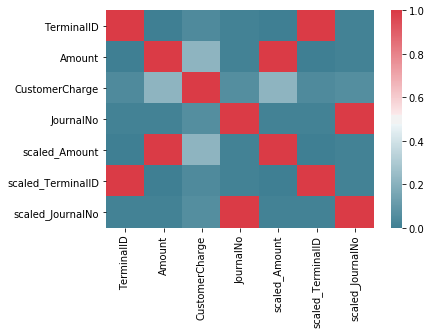

In [82]:
corr = df.loc[:,df.dtypes == 'float64'].corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap=sns.diverging_palette(220, 10, as_cmap=True))

Text(0, 0.5, '# transactions')

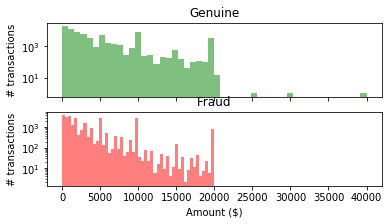

In [83]:
fig, (ax3,ax4) = plt.subplots(2,1, figsize = (6,3), sharex = True)
ax3.hist(df.Amount[df.AuditStatus==0],bins=50,color='g',alpha=0.5)
ax3.set_yscale('log') # to see the tails
ax3.set_title('Genuine') # to see the tails
ax3.set_ylabel('# transactions')
ax4.hist(df.Amount[df.AuditStatus==1],bins=50,color='r',alpha=0.5)
ax4.set_yscale('log') # to see the tails
ax4.set_title('Fraud') # to see the tails
ax4.set_xlabel('Amount ($)')
ax4.set_ylabel('# transactions')

<a id='naivebayes'></a>
####  Using Gaussian Naive Bayes

In [84]:
def split_data(df, drop_list):
    df = df.drop(drop_list,axis=1)
    print(df.columns)
    #test train split time
    from sklearn.model_selection import train_test_split
    y = df['AuditStatus'].values #target
    X = df.drop(['AuditStatus'],axis=1).values #features
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42, stratify=y)

    print("train-set size: ", len(y_train),
      "\ntest-set size: ", len(y_test))
    print("fraud cases in test-set: ", sum(y_test))
    return X_train, X_test, y_train, y_test

In [85]:
def get_predictions(clf, X_train, y_train, X_test):
    # create classifier
    clf = clf
    # fit it to training data
    clf.fit(X_train,y_train)
    # predict using test data
    y_pred = clf.predict(X_test)
    # Compute predicted probabilities: y_pred_prob
    y_pred_prob = clf.predict_proba(X_test)
    #for fun: train-set predictions
    train_pred = clf.predict(X_train)
    print('train-set confusion matrix:\n', confusion_matrix(y_train,train_pred)) 
    return y_pred, y_pred_prob

In [86]:
def print_scores(y_test,y_pred,y_pred_prob):
    print('test-set confusion matrix:\n', confusion_matrix(y_test,y_pred)) 
    print("recall score: ", recall_score(y_test,y_pred))
    print("precision score: ", precision_score(y_test,y_pred))
    print("f1 score: ", f1_score(y_test,y_pred))
    print("accuracy score: ", accuracy_score(y_test,y_pred))
    print("ROC AUC: {}".format(roc_auc_score(y_test, y_pred_prob[:,1])))

In [87]:
drop_list = []
X_train, X_test, y_train, y_test = split_data(df, drop_list)
y_pred, y_pred_prob = get_predictions(GaussianNB(), X_train, y_train, X_test)
print_scores(y_test,y_pred,y_pred_prob)

Index(['CSPCode', 'TerminalID', 'TxnDateTime', 'TxnType', 'FromAccount',
       'ToAccount', 'Amount', 'CustomerCharge', 'JournalNo', 'AuditStatus',
       'scaled_Amount', 'scaled_TerminalID', 'scaled_JournalNo'],
      dtype='object')
train-set size:  80000 
test-set size:  20000
fraud cases in test-set:  5852
train-set confusion matrix:
 [[55766   826]
 [22529   879]]
test-set confusion matrix:
 [[13949   199]
 [ 5624   228]]
recall score:  0.03896103896103896
precision score:  0.5339578454332553
f1 score:  0.07262302914476827
accuracy score:  0.70885
ROC AUC: 0.6328228766456971


In [88]:
# Case-NB-2 : drop some of principle components that have similar distributions in above plots 
drop_list = ['TerminalID','JournalNo','TerminalID','Amount','JournalNo','scaled_TerminalID','scaled_JournalNo','FromAccount','ToAccount','TxnDateTime']

#  one hot encoding of columns 
csp_code = pd.get_dummies(df['CSPCode'])
txn_type = pd.get_dummies(df['TxnType'])

# Drop columns as it is now encoded
df = df.drop('CSPCode',axis = 1)
df = df.drop('TxnType',axis = 1)

# Join the encoded df
df = df.join(csp_code)
#df = df.join(txn_type)

X_train, X_test, y_train, y_test = split_data(df, drop_list)
y_pred, y_pred_prob = get_predictions(GaussianNB(), X_train, y_train, X_test)
print_scores(y_test,y_pred,y_pred_prob)

Index(['CustomerCharge',    'AuditStatus',  'scaled_Amount',                0,
                      1,                2,                3,                4,
                      5,                6,
       ...
                   2422,             2423,             2424,             2425,
                   2426,             2427,             2428,             2429,
                   2430,             2431],
      dtype='object', length=2435)
train-set size:  80000 
test-set size:  20000
fraud cases in test-set:  5852
train-set confusion matrix:
 [[20146 36446]
 [  493 22915]]
test-set confusion matrix:
 [[5057 9091]
 [ 227 5625]]
recall score:  0.9612098427887902
precision score:  0.38223702092960044
f1 score:  0.5469661610268377
accuracy score:  0.5341
ROC AUC: 0.6603073303680979


In [89]:
# let us check recall score for logistic regression
# Case-LR-1
y_pred, y_pred_prob = get_predictions(LogisticRegression(C = 0.01, penalty = 'l1')
                                      , X_train, y_train, X_test)
print_scores(y_test,y_pred,y_pred_prob)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


train-set confusion matrix:
 [[56592     0]
 [23408     0]]
test-set confusion matrix:
 [[14148     0]
 [ 5852     0]]
recall score:  0.0
precision score:  0.0
f1 score:  0.0
accuracy score:  0.7074
ROC AUC: 0.5560515389889638


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [90]:
# get indices for fraud and genuine classes 
fraud_ind = np.array(df[df.AuditStatus == 1].index)
gen_ind = df[df.AuditStatus == 0].index
n_fraud = len(df[df.AuditStatus == 1])
# random selection from genuine class
random_gen_ind = np.random.choice(gen_ind, n_fraud, replace = False)
random_gen_ind = np.array(random_gen_ind)
# merge two class indices: random genuine + original fraud
under_sample_ind = np.concatenate([fraud_ind,random_gen_ind])
# Under sample dataset
undersample_df = df.iloc[under_sample_ind,:]
y_undersample  = undersample_df['AuditStatus'].values #target
X_undersample = undersample_df.drop(['AuditStatus'],axis=1).values #features

print("# transactions in undersampled data: ", len(undersample_df))
print("% genuine transactions: ",len(undersample_df[undersample_df.AuditStatus == 0])/len(undersample_df))
print("% fraud transactions: ", sum(y_undersample)/len(undersample_df))

# transactions in undersampled data:  58520
% genuine transactions:  0.5
% fraud transactions:  0.5


In [91]:
# let us train logistic regression with undersamples data
# Case-LR-2
# split undersampled data into 80/20 train-test datasets. 
# - Train model from this 80% fraction of undersampled data, get predictions from left over i.e. 20%.
drop_list = []
X_und_train, X_und_test, y_und_train, y_und_test = split_data(undersample_df, drop_list)
y_und_pred, y_und_pred_prob = get_predictions(LogisticRegression(C = 0.01, penalty = 'l1'), X_und_train, y_und_train, X_und_test)
print_scores(y_und_test,y_und_pred,y_und_pred_prob)

Index([       'TerminalID',       'TxnDateTime',       'FromAccount',
               'ToAccount',            'Amount',    'CustomerCharge',
               'JournalNo',       'AuditStatus',     'scaled_Amount',
       'scaled_TerminalID',
       ...
                      2422,                2423,                2424,
                      2425,                2426,                2427,
                      2428,                2429,                2430,
                      2431],
      dtype='object', length=2443)
train-set size:  46816 
test-set size:  11704
fraud cases in test-set:  5852


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


train-set confusion matrix:
 [[13550  9858]
 [10451 12957]]
test-set confusion matrix:
 [[3398 2454]
 [2604 3248]]
recall score:  0.5550239234449761
precision score:  0.5696246930901439
f1 score:  0.5622295308983902
accuracy score:  0.5678400546821599
ROC AUC: 0.6043696787796871


In [92]:
# Case-LR-3
# "train" with undersamples, "test" with full data
# call classifier
lr = LogisticRegression(C = 0.01, penalty = 'l1')
# fit it to complete undersampled data
lr.fit(X_undersample, y_undersample)
# predict on full data
y_full = df['AuditStatus'].values #target
X_full = df.drop(['AuditStatus'],axis=1).values #features
y_full_pred = lr.predict(X_full)
# Compute predicted probabilities: y_pred_prob
y_full_pred_prob = lr.predict_proba(X_full)
print("scores for Full set")   
print('test-set confusion matrix:\n', confusion_matrix(y_full,y_full_pred)) 
print("recall score: ", recall_score(y_full,y_full_pred))
print("precision score: ", precision_score(y_full,y_full_pred))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


scores for Full set
test-set confusion matrix:
 [[41192 29548]
 [12948 16312]]
recall score:  0.5574846206425154
precision score:  0.3556912341910161


<a id='xgboost'></a>
####  Compare the scores from GaussianNB with logistic-regression.

Get predictions for test-dataset (20% of full dataset) from both models.
Aim is to compare recall score of Case-NB-4 with Case-LR-4.

In [26]:
drop_list = []
X_train, X_test, y_train, y_test = split_data(df, drop_list)

Index([    'TerminalID',    'TxnDateTime',    'FromAccount',      'ToAccount',
               'Amount', 'CustomerCharge',      'JournalNo',      'TxnStatus',
          'AuditStatus',  'scaled_Amount',
       ...
                   2422,             2423,             2424,             2425,
                   2426,             2427,             2428,             2429,
                   2430,             2431],
      dtype='object', length=2444)
train-set size:  80000 
test-set size:  20000
fraud cases in test-set:  5852


In [ ]:
y_p20_pred = lr.predict(X_test)
y_p20_pred_prob = lr.predict_proba(X_test)
print("scores for test (20% of full) set")   
print('test-set confusion matrix:\n', confusion_matrix(y_test,y_p20_pred)) 
print("recall score: ", recall_score(y_test,y_p20_pred))
print("precision score: ", precision_score(y_test,y_p20_pred))

<a id='xgboost'></a>
####  Using XGBoost

In [27]:
print(df.columns)

#test train split time
from sklearn.model_selection import train_test_split
y = df['AuditStatus'].values #target
X = df.drop(['AuditStatus'],axis=1).values #features
trainX, testX, trainY, testY = train_test_split(X, y, test_size=0.2,
                                                    random_state=42, stratify=y)

print("train-set size: ", len(trainY),
      "\ntest-set size: ", len(testY))
print("fraud cases in test-set: ", sum(testY))


Index([    'TerminalID',    'TxnDateTime',    'FromAccount',      'ToAccount',
               'Amount', 'CustomerCharge',      'JournalNo',      'TxnStatus',
          'AuditStatus',  'scaled_Amount',
       ...
                   2422,             2423,             2424,             2425,
                   2426,             2427,             2428,             2429,
                   2430,             2431],
      dtype='object', length=2444)
train-set size:  80000 
test-set size:  20000
fraud cases in test-set:  5852


In [28]:
# Long computation in this cell (~1.8 minutes)
weights = (Y == 0).sum() / (1.0 * (Y == 1).sum())
clf = XGBClassifier(max_depth = 3, scale_pos_weight = weights, \
                n_jobs = 4)
probabilities = clf.fit(trainX, trainY).predict_proba(testX)
print('AUPRC = {}'.format(average_precision_score(testY, \
                                              probabilities[:, 1])))

AUPRC = 0.568447713250235


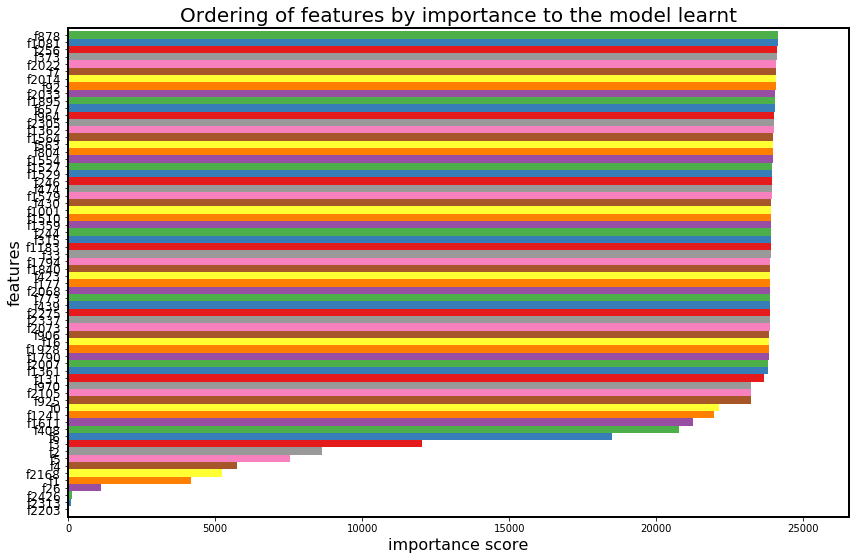

In [29]:
fig = plt.figure(figsize = (14, 9))
ax = fig.add_subplot(111)

colours = plt.cm.Set1(np.linspace(0, 1, 9))

ax = plot_importance(clf, height = 1, color = colours, grid = False, \
                     show_values = False, importance_type = 'cover', ax = ax);
for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2)
        
ax.set_xlabel('importance score', size = 16);
ax.set_ylabel('features', size = 16);
ax.set_yticklabels(ax.get_yticklabels(), size = 12);
ax.set_title('Ordering of features by importance to the model learnt', size = 20);

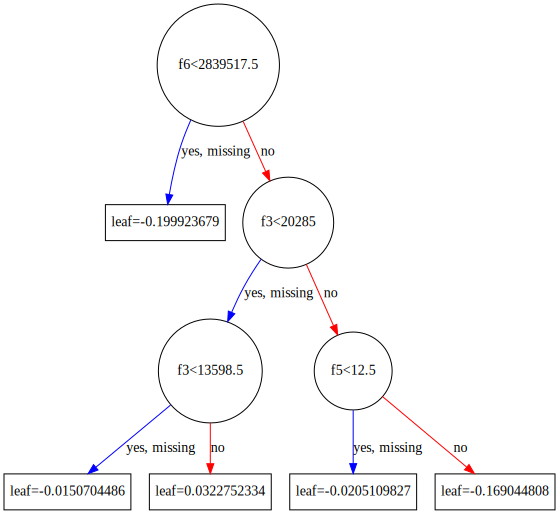

In [30]:
to_graphviz(clf)